In [16]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [18]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [19]:
scores = scores[(scores != 0).all(1)]

In [20]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [21]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [22]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

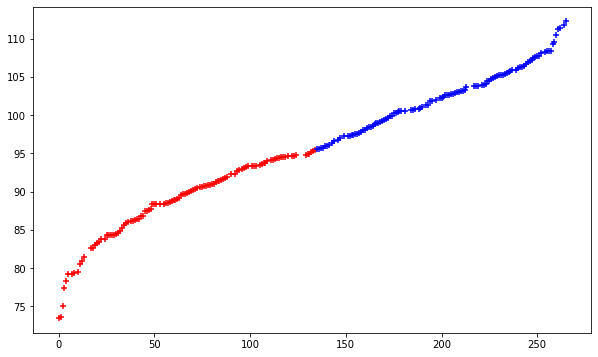

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [24]:
from Modules.dataprocessing import ProcessingData

a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])
display(preview_table)

,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Travel Connectivity,Commute,Business Freedom,Safety,...,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors,Naive Sum,Label
0,Milan,Italy,Europe,0.466056,0.422333,0.465611,0.643984,0.794909,0.472180,0.697106,...,0.410705,0.380111,0.257194,0.117856,0.460532,0.768556,0.693198,0.691645,0.538576,worse
1,Quebec,Canada,Europe,0.835278,0.559667,0.303833,0.074970,0.755795,0.856767,0.902905,...,0.534144,0.709004,0.562573,0.682120,0.263710,0.515167,0.864016,0.567604,0.809336,better
2,Malaga,Spain,Europe,0.783500,0.708333,0.162056,0.394709,0.840555,0.601007,0.733495,...,0.353816,0.800247,0.372235,0.287847,0.595399,0.598778,0.727422,0.710884,0.817337,better
3,Portland,Oregon,North America,0.348667,0.436000,0.661889,0.167168,0.693079,0.815902,0.443251,...,0.403376,0.840676,0.645634,0.290938,0.570044,0.579944,0.807685,0.780842,0.448675,worse
4,Turku,Finland,Europe,0.726000,0.452222,0.097722,0.272727,1.000000,0.923905,0.904754,...,0.526273,0.914943,0.326021,0.402671,0.651962,0.455278,0.757993,0.543186,0.836540,better
188,Cambridge,United Kingdom,Europe,0.345056,0.427889,0.472556,0.665933,0.814423,0.860368,0.942760,...,0.657312,0.789687,0.512971,0.528167,0.551801,0.161667,0.847573,0.000000,0.817952,better
189,Salt Lake City,Utah,North America,0.571222,0.574667,0.588889,0.220457,0.636770,0.815902,0.498296,...,0.410433,0.582425,0.645634,0.324003,0.666648,0.548000,0.864076,0.826181,0.568766,better
190,Singapore,Singapore,Asia,0.082778,0.276556,0.900333,0.246753,0.780620,0.961860,0.996708,...,0.841005,0.782522,0.764434,0.995218,0.854406,0.713611,0.604957,0.717611,0.901810,better
192,Boise,Idaho,North America,0.662611,0.619778,0.356111,0.068745,0.746523,0.815902,0.348524,...,0.339214,0.795787,0.645634,0.307441,0.280174,0.355500,0.657634,0.635141,0.382952,worse
193,Berlin,Germany,Europe,0.599444,0.502667,0.898333,0.680691,0.910225,0.871497,0.682493,...,0.707741,0.646390,0.505022,0.288955,0.421983,0.875667,0.688082,0.669313,0.930874,better


In [28]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TriangularFunction
from Modules.norms import AdditiveNorm
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TriangularFunction(0, 0, 0.4))
fuzzy.add_antecedent('Housing', 'Mid', TriangularFunction(0.3, 0.4, 0.8))
fuzzy.add_antecedent('Housing', 'Good', TriangularFunction(0.7, 1, 1))

fuzzy.add_antecedent('Startups', 'Bad', TriangularFunction(0, 0, 0.3))
fuzzy.add_antecedent('Startups', 'Mid', TriangularFunction(0.2, 0.4, 0.6))
fuzzy.add_antecedent('Startups', 'Good', TriangularFunction(0.5, 0.8, 1))

fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Bad', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Mid', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Bad', 'Startups': 'Good', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Bad', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Mid', 'Rating': 'Bad'})
fuzzy.add_rule({'Housing' : 'Mid', 'Startups': 'Good', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Bad', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Mid', 'Rating': 'Good'})
fuzzy.add_rule({'Housing' : 'Good', 'Startups': 'Good', 'Rating': 'Good'})

fuzzy.add_consequent('Rating', 'Bad', TriangularFunction(0, 0, 0.5))
fuzzy.add_consequent('Rating', 'Good', TriangularFunction(0.5, 1, 1))

for i in range(5):
    sample = a.iloc[i]
    result = fuzzy.compute(sample, 'fom')
    print(f'{sample["UA_Name"]} -> {result}')

crisp_result=1
Milan -> Good
crisp_result=1
Quebec -> Good
crisp_result=1
Malaga -> Good
crisp_result=1
Portland -> Good
crisp_result=1
Turku -> Good


In [26]:
import Modules.fuzzysys as fsys
from Modules.membership_functions import TrapezoidalFunction
importlib.reload(fsys)

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', 'Bad', TrapezoidalFunction(0, 0.2, 0.4, 0.6))
fuzzy.add_antecedent('Housing', 'Mid', TrapezoidalFunction(0.1, 0.3, 0.5, 0.7))
fuzzy.add_antecedent('Housing', 'Good', TrapezoidalFunction(0.3, 0.5, 0.7, 1))

fuzzy.add_antecedent('Startups', 'Bad', TrapezoidalFunction(0, 0.3, 0.6, 0.9))
fuzzy.add_antecedent('Startups', 'Mid', TrapezoidalFunction(0.1, 0.4, 0.7, 1))
fuzzy.add_antecedent('Startups', 'Good', TrapezoidalFunction(0.05, 0.25, 0.45, 0.65))

for i in range(5):
    sample = a.iloc[i].to_dict()
    fuzzified_sample = fuzzy.fuzzify(sample)
    print(f'{sample["UA_Name"]} -> {fuzzified_sample}')

TypeError: FuzzySystem.__init__() missing 1 required positional argument: 'norm'